In [47]:
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Load preprocessor, model and data

In [48]:
preprocessor = pickle.load(open("preprocessor.pkl","rb"))
lgbm_model = pickle.load(open("lgbm_model.pkl","rb"))

- Charger les données d'environ 20 000 clients(CustomerDataToBePredicted.csv) sur les plus de 90 000 sauvegardés(customer_data_test.csv)
- Pourquoi ?
    * Réduire le temps de chargement API et Dashboard
    * Ne pas dépasser le taille de fichier conseillé par git (50 Mo warning, 100 Mo error)
    * Ne pas avoir d'erreur lors du déploiement (R15 error memory notamment)
    * Ne pas être forcé d'utiliser git lfs (non pris en charge avec Heroku sans configuration précise)
    * Charger 20 000 ou 90 000 lignes donnent les mêmes résultats pour l'analyse de la feature importance globale et locale avec Shap
- Chacun est libre de prendre évidemment la taille de CSV qu'il veut parmis 'customer_data_test.csv'

In [49]:
inputs = pd.read_csv('CustomerDataToBePredicted.csv')
inputs.sort_values(by='SK_ID_CURR', inplace=True)
inputs.set_index(keys='SK_ID_CURR', inplace=True)

In [50]:
inputs.shape

(20653, 339)

### Pour extraire des informations du modèle
- La première étape est sûrement l’approche globale qui consiste à définir l’importance des variables du modèle de manière globale.
- La seconde étape consiste à changer d’échelle afin d’extraire des informations locales pour des exemples spécifiques de notre dataset.

## Feature importance global

In [51]:
import shap

In [52]:
def calculate_explainer_shapval_and_means(classifier, feature_inputs):
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(feature_inputs)
    mean_values = np.abs(shap_values).mean(0)
    return explainer, shap_values, mean_values

lgbm_explainer, lgbm_shap_values, lgbm_mean_values = calculate_explainer_shapval_and_means(lgbm_model, inputs)

In [53]:
def feature_importance_global_graphics(feature_inputs, shap_values):
    plt.title("Feature importance global", size=20)
    shap.summary_plot(shap_values, feature_inputs, plot_type='bar')
    shap.summary_plot(shap_values[0], feature_inputs)
    plt.show()
    return

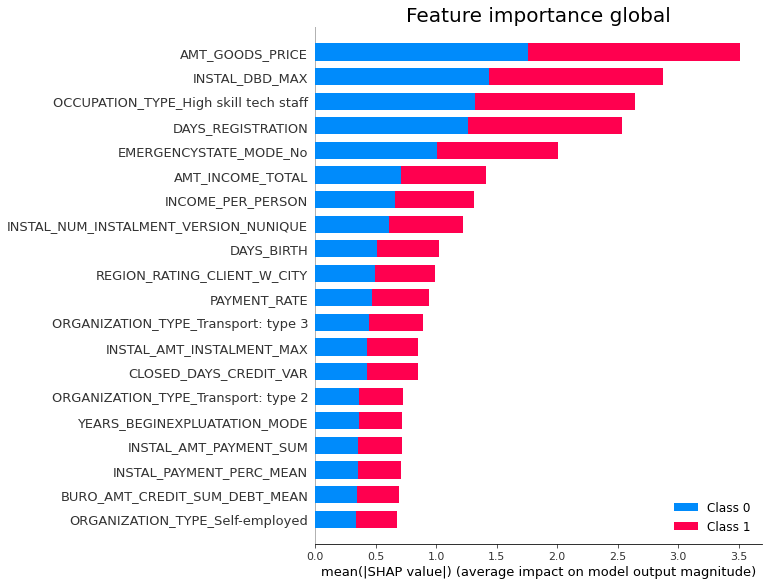

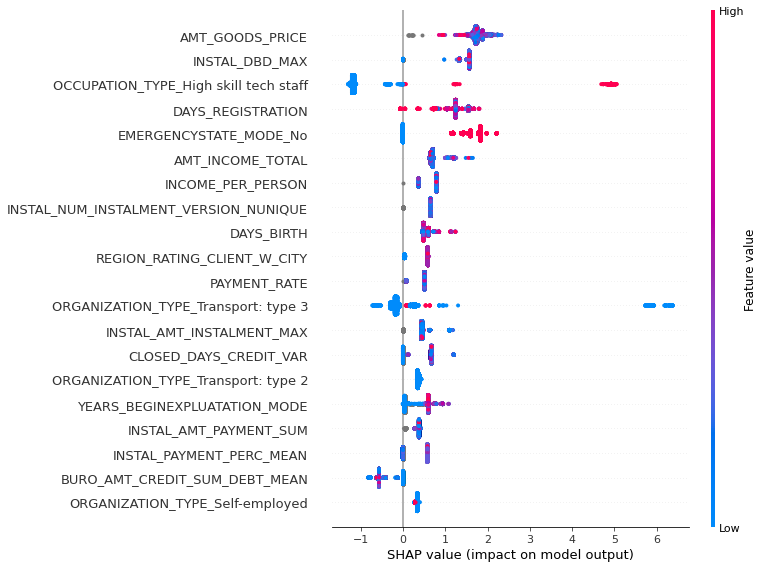

In [54]:
feature_importance_global_graphics(inputs, lgbm_shap_values)

- Sur l’image du haut, l’importance des variables est calculée en moyennant la valeur absolue des valeurs de Shap. En bas, les valeurs de Shap sont représentées pour chaque variable dans leur ordre d’importance, chaque point représente une valeur de Shap (pour un exemple), les points rouges représentent des valeurs élevées de la variable et les points bleus des valeurs basses de la variable.

- On a une information supplémentaire sur l’impact de la variable en fonction de sa valeur. Par exemple AMT_GOOD_PRICES qui est la variable la plus importante, a un impact négatif quand la valeur de cette variable est élevée.

## Graphiques

In [55]:
import seaborn as sns

In [56]:
def predict_all_data(data, preprocess, model):
    data_copy = data.copy()
    data_customer_preprocess = preprocess.transform(data_copy)
    y_pred = model.predict(data_customer_preprocess).tolist()
    y_prob = model.predict_proba(data_customer_preprocess).tolist()
    data_copy['predict'] = y_pred
    data_copy['list_of_proba'] = y_prob
    return data_copy

In [57]:
data_predict = predict_all_data(inputs, preprocessor, lgbm_model)
data_predict.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: 

In [58]:
discrete_variables = sorted(inputs.loc[:, inputs.nunique() < 10].columns.tolist())
continuous_variables = sorted(inputs.loc[:, inputs.nunique() >= 10].columns.tolist())
all_variables = sorted(continuous_variables + discrete_variables)

In [192]:
def predict_class_and_proba_customer(data, id_, preprocess, model):
    data_id_customer = data.loc[id_].to_frame().T
    data_customer_preprocess = preprocess.transform(data_id_customer)
    y_pred = model.predict(data_customer_preprocess)[0]
    y_prob = model.predict_proba(data_customer_preprocess)[0].tolist()
    if y_pred == 0:
        return "Prêt accordé" + " ->  Probabilité:" + f"{y_prob[0]}"
    else:
        return "Prêt Refusé" + " ->  Probabilité:" + f"{y_prob[1]}"


def feature_importance_local_graphics(id_, top_n_features):
    plt.title("Feature importance local", size=20)
    plt.xlabel("Effect - SHAP value- Prediction value", size=12)
    index_id_ = list_of_ids_in_order.index(id_)
    shap.plots._waterfall.waterfall_legacy(lgbm_explainer.expected_value[1], lgbm_shap_values[0][index_id_],
                                           features=inputs.loc[id_], max_display=top_n_features)
    plt.show()
    return

def boxplot_by_feature(df, feature_name):
    fig1 = plt.figure(figsize=(10, 8))
    plt.title("Représentation schématique des quartiles, médiane et moyenne", size=15)
    sns.boxplot(data=df[[feature_name]], showfliers=False, showmeans=True)
    fig1.show()
    fig2 = plt.figure(figsize=(10, 8))
    plt.title("Séparation entre Prêt accordé et Prêt refusé", size=15)
    sns.boxplot(x='predict', y=feature_name, showfliers=False, showmeans=True, data=df)
    fig2.show()
    return fig1, fig2

def barplot_by_feature(df, feature_name):
    plt.title("Répartition des valeurs et Séparation entre Prêt accordé et Prêt refusé", size=15)
    df = df.copy()
    df['Count'] = 1
    df = df[[feature_name, 'predict', 'Count']].groupby([feature_name, 'predict']).count().reset_index()
    sns.barplot(x=df[feature_name], y=df.Count, hue=df.predict)
    plt.xticks(rotation=0)
    plt.show()
    return

def box_or_bar_plot(df, feature_name, id_):
    if feature_name in continuous_variables:
        boxplot_by_feature(df, feature_name)
        print('Value: ', df.loc[id_][feature_name])
    else:
        barplot_by_feature(df, feature_name)
        print('Value: ', df.loc[id_][feature_name])

## Select a proba treshold

In [193]:
def extract_proba(x, i):
    return x[i]

In [194]:
list_of_ids_in_order = inputs.index.tolist()

In [213]:
data_predict_0 = data_predict[data_predict.predict == 0]
data_predict_0['proba'] = data_predict_0.list_of_proba.apply(extract_proba, i=0)
list_of_best_customer_ids = data_predict_0[data_predict_0.proba > 0.95].head(10).index.tolist()

data_predict_1 = data_predict[data_predict.predict == 1]
data_predict_1['proba'] = data_predict_1.list_of_proba.apply(extract_proba, i=1)
list_of_worst_customer_ids = data_predict_1[data_predict_1.proba > 0.95].head(10).index.tolist()

In [214]:
list_of_best_customer_ids

[100003,
 100022,
 100029,
 100037,
 100046,
 100101,
 100132,
 100136,
 100143,
 100159]

In [215]:
list_of_worst_customer_ids

[100396,
 101106,
 102576,
 102768,
 102865,
 102939,
 103778,
 103973,
 104262,
 104280]

##  Examples: un client dont on accorde le prêt, un client dont on refuse le prêt
- Bon client: ID 100 101
- Mauvais client : ID 100396

- Il s'agit dans cette partie de montrer 2 exemples d'un client dont le prêt est accepté et d'un autre dont le prêt est refusé.
    * Changer L'ID du client que vous souhaitez analyser
    * Changer ensuite le critère que vous souhaitez analyser (Barplot pour les valeurs continues, Boxplot pour les valeurs discrètes)

In [329]:
# 100101
# 100396
user_id = 100101

In [330]:
predict_class_and_proba_customer(data=inputs, id_=user_id, preprocess=preprocessor, model=lgbm_model)

'Prêt accordé ->  Probabilité:0.9892333931357692'

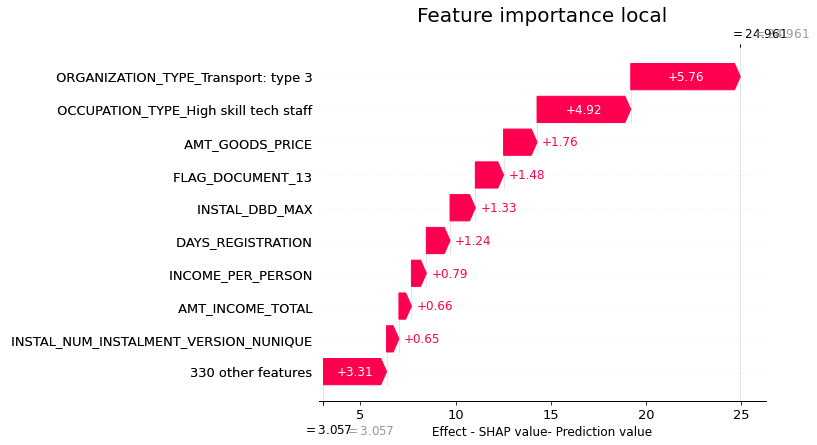

In [331]:
feature_importance_local_graphics(id_=user_id, top_n_features=10)

### En rouge, les variables qui ont un impact positif (contribuent à ce que la prédiction soit plus élevée que la valeur de base) et, en bleu, celles ayant un impact négatif (contribuent à ce que la prédiction soit plus basse que la valeur de base). J'affiche ici les 9 critères les plus influents du modèle qui a prédit un prêt accordé ou un prêt refusé.

### 1. Client - ID 100 101 (Good client)

#### La valeur de base du dataset est à 3.057, la prédiction est de 24.961. Cet exemple a une prédiction de valeur bien plus élevée que la moyenne. On remarque qu'en affichant le top 9 des meilleurs critères, les 330 autres critères contribuent positivement qu'à 2.47 pour faire monter la valeur de prédiction, presque autant que le critère le plus influent AMT GOODS PRICE !

- Organization type Transport: type 3: 
    * Le type d'organisation où le client travaille influe sur la prédiction de manière globale notamment si il est dans le transport (type 2 ou 3 comme vu sur le schéma global). En particulier pour ce client(1ère position des critères), il y a une grande contribution positive de +5.76 pour que la prédiction soit plus élevée.
    * Sur le Barplot, nous voyons la répartition des valeurs pour une variable continue. Dans notre cas, c'est une variable binaire (0 si le client ne fait partie d'une organisation de transport type 3, 1 s'il en fait partie). Notre client n'en fait pas partie (valeur 0), tout comme plus de 15 000 clients à qui on a accordé un prêt (bleu).
    * Attention, à peu près 5000 clients dont le prêt est refusé (orange) aussi ne font pas partie d'une organisation de transport. Très peu de clients font partie de cette organisation. Etant donné que nous avons une classe largement majoritaire, ce graphique ne nous permet pas de conclure à quelque chose. Autrement dit, pour ce client précisément, le fait qu'il ne fasse pas partie de cette organisation a fortement augmenté la prédiction, par rapport aux nombreux autres critères.
    
- Occupation type high skill tech staff: 
    * De manière globale, on remarque sur le schéma précédent que le fait de faire partie de ce type de profession augmente la shap value, et inversement.
    * Le type de profession du client influe beaucoup sur la prédiction comme on l'a vu de manière globale (3ème position), et en particulier pour ce client hautement qualifié.(2ème position avec une contribution positive de +4.92)
    * Ce qui est intéressant sur le Barplot, c'est que même si on ne voit pas beaucoup de clients faisant partie de ce type de profession 'hautement qualifiée', la plupart de ceux qui en font partie (valeur 1) ont un prêt accordé(bleu). On remarque donc une tendance positive à être hautement qualifié pour l'accord d'un prêt, ce qui est logique.
    
- AMT goods price: Le prix du bien immobilier influe aussi logiquement (1ère position globalement). Ici, Contribution positive à +1.76.
    * De manière globale, comme on le voit sur le schéma précédent, plus la valeur de ce critère est bas, plus la shap value est grande. Ceci est logique, on accorde plus facilement un prêt à un immobilier pas cher.
    * Or, sur le Boxplot représentant les quartiles ainsi que la moyenne pour ce critère, et en prenant en compte la séparation entre prêt accordé et refusé, on remarque que la médiane est semblable (approximativement 0.50 e6) mais la moyenne pour les clients acceptés est plus haute est pour les clients refusés. Ceci est cependant logique, la majorité des clients à qui on accorde un prêt ont de meilleurs critères que ceux à qui on refuse un prêt, et vise plus souvent les immobilier plus cher.
    * On regarde donc la valeur du critère (0.283 e6). C'est bien en dessous de la moyenne(0.60) et de la médiane (0.50) des clients acceptés tout comme la moyenne(0.50) et la médiane(0.50) des clients refusées. D'où l'effet positif de ce critère.
    
- Instal DBD MAX: 
    * Le maximum du nombre de jours d'avance du paiement du crédit précédent pour un client est également important. On l'a remarqué de façon globale tout à l'heure, et, pour ce client, +1.33 d'effet sur la prédiction.
    * De manière globale, même si c'est moins net sur le schéma précédent, on remarque que plus ce critère est grand, plus la shap value sera grande. Avec un peu de logique on s'en rend compte, ce critère correspondant au nombre maximum de jours d'avances du paiement du dernier crédit du client.
    * Regardons le boxplot, le box des acceptées est plus haut que celui des refusées (médiane, moyenne et 3ème quartile). La tendance est logique, plus l'avance de paiement de l'ancien crédit est grande, plus il y a de chance d'avoir un prêt accepté.
    * La valeur est de 41, qui correspond à la moyenne du box des clients acceptées. D'où l'effet positif de ce critère.

- AMT income total: Le revenu du client, enfin est évidemment un critère majeur pour accorder un prêt ou non. Ici, +0.66 pour sa contribution.
    * Plus un client gagne un bon revenu, plus sa probabilité de voir son prêt accepté sera élevée. (+0.66 graphe locale)
    * Sur le boxplot, médiane, moyenne et 3eme quartile plus grand pour le box des clients acceptées que celui des clients refusées (de façon logique)
    * La valeur du revenu (202 500 euros) du client est au-dessus de la médiane (175 000 euros) et correspond environ à la moyenne (pour le box des acceptées).

### 2. Client - ID 100396 (Bad client)

#### La valeur de base du dataset est à 3.057, la prédiction est de 12.825. Cet exemple a une prédiction de valeur bien plus élevée que la moyenne.

- Occupation type high skill tech staff: 
    * Pour ce client non hautement qualifié, nous avons donc une contribution négative (- 1.16 pour la prédiction)
    
- AMT goods price: Le prix du bien immobilier influe aussi logiquement (1ère position globalement). Ici, Contribution positive à +1.76.
    * On remarque ici que le client veut un bien à 360 000 euros, plus cher que le précédent client. Cela reste en dessous des médianes et moyenne pour les box général/0/1 pour ce critère. Donc effet positif du critère (+1.98 d'ailleurs sur le schéma local). Ce critère est le plus influent dans la prédiction du modèle pour ce client.
    
#### Je m'arrête ici pour ce client, mais on pourrait continuer comme cela avec tous les autres critères.

In [333]:
# ORGANIZATION_TYPE_Transport: type 3
# INSTAL_DBD_MAX
# AMT_INCOME_TOTAL

## Critères communs pour la comparaison
# OCCUPATION_TYPE_High skill tech staff / Bon client: Value 1 - Mauvais client: Value 0
# AMT_GOODS_PRICE / Bon client: Value 283 000 euros - Mauvais client: Value 360 000 euros
user_feature = 'AMT_INCOME_TOTAL'

Value:  202500.0


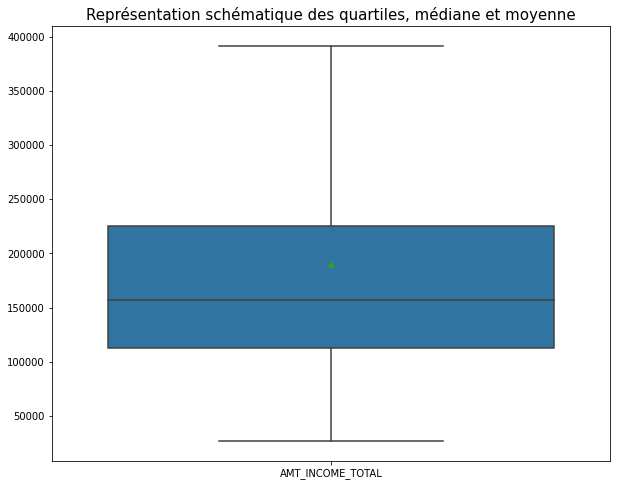

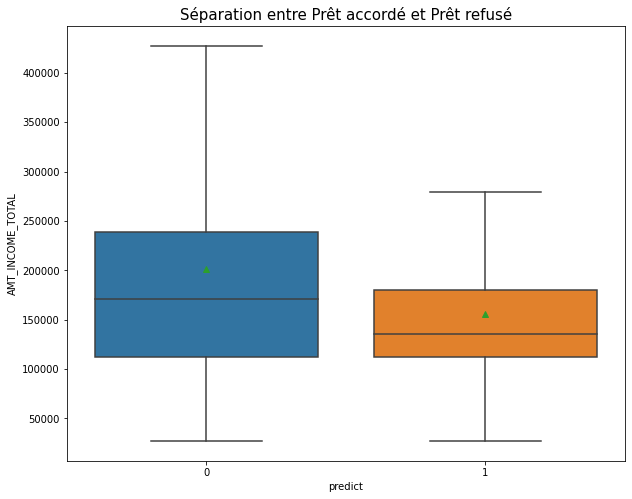

In [334]:
box_or_bar_plot(df=data_predict, feature_name=user_feature, id_=user_id)

## Clean Description

- Cleaner le csv de description des variables

In [335]:
def load_and_clean_description():
    df = pd.read_csv('input/HomeCredit_columns_description.csv', index_col=0)
    df.sort_values(by='Row', inplace=True)
    df = df[['Row', 'Description']]
    df.drop_duplicates(inplace=True)
    df.drop([179, 141, 176, 145, 150, 173, 126, 178, 174, 197, 152, 181, 185, 183, 155, 184, 125], inplace=True)
    return df

In [336]:
hc_col_desc = load_and_clean_description()
hc_col_desc

,Row,Description
12,AMT_ANNUITY,Loan annuity
180,AMT_APPLICATION,For how much credit did client ask on the prev...
156,AMT_BALANCE,Balance during the month of previous credit
11,AMT_CREDIT,Credit amount of the loan
157,AMT_CREDIT_LIMIT_ACTUAL,Credit card limit during the month of the prev...
...,...,...
77,YEARS_BEGINEXPLUATATION_MEDI,Normalized information about building where th...
63,YEARS_BEGINEXPLUATATION_MODE,Normalized information about building where th...
50,YEARS_BUILD_AVG,Normalized information about building where th...
78,YEARS_BUILD_MEDI,Normalized information about building where th...


In [337]:
# hc_col_desc.Row.tolist()

In [338]:
# hc_col_desc.to_csv('home_credit_feature_description.csv', index=False)

- Afficher la description de la variable souhaitée

In [339]:
def print_description(df_description, feature_name):
    print(hc_col_desc[hc_col_desc.Row == feature_name].Description.values[0])

In [340]:
query = 'AMT_INCOME_TOTAL'
print_description(df_description=hc_col_desc, feature_name=query)

Income of the client


## Nouvelles variables (ne faisant pas partie de la liste des descriptions)

### Par le calcul
- DAYS_EMPLOYED_PERC = DAYS_EMPLOYED / DAYS_BIRTH
- INCOME_CREDIT_PERC = AMT_INCOME_TOTAL / AMT_CREDIT
- INCOME_PER_PERSON = AMT_INCOME_TOTAL / CNT_FAM_MEMBERS
- ANNUITY_INCOME_PERC = AMT_ANNUITY/ AMT_INCOME_TOTAL
- PAYMENT_RATE = AMT_ANNUITY / AMT_CREDIT

- PAYMENT_PERC = AMT_PAYMENT / AMT_INSTALMENT (Percentage paid in each installment (amount paid and installment value))
- PAYMENT_DIFF = AMT_INSTALMENT - AMT_PAYMENT (Difference paid in each installment (amount paid and installment value))
- DPD = DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT (Days past due)
- DBD = DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT (days before due)

### Par encodage(one hot encoder, pour les variables catégorielles)
- Exemples: occupation type -> Tous les types d'occupation deviennent des critères binaire (non 0, oui 1), organization type etc..

### Minimum, Maximum, Moyenne, Vaiance, Somme (Ajout suffixe)
- Ajout de min, max, mean, var, sum en suffixe pour certaines variables

### Ajout préfixe selon les données d'où est extraite la variable
- BURO_,
- ACTIVE_ (Crédit activé)
- CLOSED_ (Crédit fermé)
- POS_ ( (point of sales) and cash loans) et POS_COUNT (cash)
- INSTAL_ et INSTAL_COUNT
- CC_ et CC_COUNT (carte de crédit)